In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import seaborn as sns
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
%matplotlib inline
import cv2
import glob
from IPython.display import Image
import scipy as sp
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import  Input, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, BatchNormalization, concatenate, GlobalAveragePooling2D
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import VGG16
import matplotlib.image as mpimg
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import shutil
import cv2
from PIL import Image
from tensorflow.keras.optimizers import Adam

In [ ]:
# get text data
image_path ="/content/drive/MyDrive/CSC180/Final Project/archive/filtered_images/"
data = pd.read_csv("/content/drive/MyDrive/CSC180/Final Project/archive/metadata/Train.csv")

In [ ]:
data.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0


In [ ]:
# Count the number of rows for each class
class_counts = data['class'].value_counts()

# Display the counts for each class
print(class_counts)

class
Trophozoite    15838
WBC             7004
NEG              688
Name: count, dtype: int64


In [ ]:
#Ashar Javid

# Group by Image_ID and just keep image ID and label
aggregated_data = data.groupby('Image_ID').agg({
    'class': lambda x: x.mode()[0]
}).reset_index()


In [ ]:
aggregated_data.head()

,Image_ID,class
0,id_0051lznyrt.jpg,Trophozoite
1,id_00m1onu6hj.jpg,NEG
2,id_00n92f65ke.jpg,NEG
3,id_00sirs797x.jpg,Trophozoite
4,id_013o32svbt.jpg,NEG


In [ ]:
# Check the unique values in the 'class' column
unique_classes = aggregated_data['class'].value_counts()

# Print the unique classes
print(unique_classes)

class
Trophozoite    1585
NEG             688
WBC             474
Name: count, dtype: int64


In [ ]:
# Filter aggregated_data for the classes you want to include
aggregated_data = aggregated_data[aggregated_data['class'].isin(['Trophozoite', 'NEG'])]

In [ ]:

# Group by 'class' and downsample to 600 samples per class
downsampled_data = aggregated_data.groupby('class').apply(lambda x: x.sample(600, random_state=42))

# Reset index to avoid multi-index after applying groupby
downsampled_data = downsampled_data.reset_index(drop=True)

# Print the downsampled class distribution
print(f"Downsampled class distribution: \n{downsampled_data['class'].value_counts()}")

Downsampled class distribution: 
class
NEG            600
Trophozoite    600
Name: count, dtype: int64


<ipython-input-69-d823c5fce5cd>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  downsampled_data = aggregated_data.groupby('class').apply(lambda x: x.sample(600, random_state=42))


In [ ]:

# Map class labels to binary values (WBC = 1, NEG = 0)
downsampled_data['class'] = downsampled_data['class'].map({'Trophozoite': 1, 'NEG': 0})
print(f" class distribution: \n{downsampled_data['class'].value_counts()}")

 class distribution: 
class
0    600
1    600
Name: count, dtype: int64


In [ ]:
y = downsampled_data['class'].values

In [ ]:
#Ashar Javid

y_train_Global, y_test_Global = train_test_split(y, test_size=0.2, random_state=42)

In [ ]:
# Count occurrences in y_train_Global
train_class_counts = pd.Series(y_train_Global).value_counts()
print("Class counts in y_train_Global:")
print(f"Class 0 (NEG): {train_class_counts[0]}")
print(f"Class 1 (Troph): {train_class_counts[1]}")

# Count occurrences in y_test_Global
test_class_counts = pd.Series(y_test_Global).value_counts()
print("\nClass counts in y_test_Global:")
print(f"Class 0 (NEG): {test_class_counts[0]}")
print(f"Class 1 (Troph): {test_class_counts[1]}")

Class counts in y_train_Global:
Class 0 (NEG): 478
Class 1 (Troph): 482

Class counts in y_test_Global:
Class 0 (NEG): 122
Class 1 (Troph): 118


In [ ]:
def load_and_preprocess_image(image_id):
    image_file = os.path.join(image_path, image_id)
    img = load_img(image_file, target_size=(128, 128))  # Resize image as needed
    img = img_to_array(img) / 255.0  # Normalize image (values between 0 and 1)

    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert RGB image to grayscale
    gray_img = np.expand_dims(gray_img, axis=-1)  # Add a channel dimension to make it (128, 128, 1)

    return img, gray_img  # Return both RGB and grayscale images

In [ ]:
# Iterate over unique_image_ids and load each image
images = []
grayImages = []
for idx, image_id in enumerate(downsampled_data['Image_ID']):
    img, gray_img = load_and_preprocess_image(image_id)
    images.append(img)
    #grayImages.append(gray_img)  # Append grayscale image

    # Print the image number being processed
    print(f"Processing image {idx + 1} of {len(downsampled_data['Image_ID'])}")

Processing image 1 of 1200
Processing image 2 of 1200
Processing image 3 of 1200
Processing image 4 of 1200
Processing image 5 of 1200
Processing image 6 of 1200
Processing image 7 of 1200
Processing image 8 of 1200
Processing image 9 of 1200
Processing image 10 of 1200
Processing image 11 of 1200
Processing image 12 of 1200
Processing image 13 of 1200
Processing image 14 of 1200
Processing image 15 of 1200
Processing image 16 of 1200
Processing image 17 of 1200
Processing image 18 of 1200
Processing image 19 of 1200
Processing image 20 of 1200
Processing image 21 of 1200
Processing image 22 of 1200
Processing image 23 of 1200
Processing image 24 of 1200
Processing image 25 of 1200
Processing image 26 of 1200
Processing image 27 of 1200
Processing image 28 of 1200
Processing image 29 of 1200
Processing image 30 of 1200
Processing image 31 of 1200
Processing image 32 of 1200
Processing image 33 of 1200
Processing image 34 of 1200
Processing image 35 of 1200
Processing image 36 of 1200
P

In [ ]:
# Convert the list of images into a numpy array
images_array = np.array(images)

# Check the shape of the final image array
print(images_array.shape)

(1200, 128, 128, 3)


In [ ]:
x_train_images, x_test_images = train_test_split(images_array, test_size=0.2, random_state=42)

In [ ]:
print(f"y_train_FNN shape: {y_train_Global.shape}, y_test_Global shape: {y_test_Global.shape}")
print(f"x_train_images shape: {x_train_images.shape}, x_test_images shape: {x_test_images.shape}")

y_train_FNN shape: (960,), y_test_Global shape: (240,)
x_train_images shape: (960, 128, 128, 3), x_test_images shape: (240, 128, 128, 3)


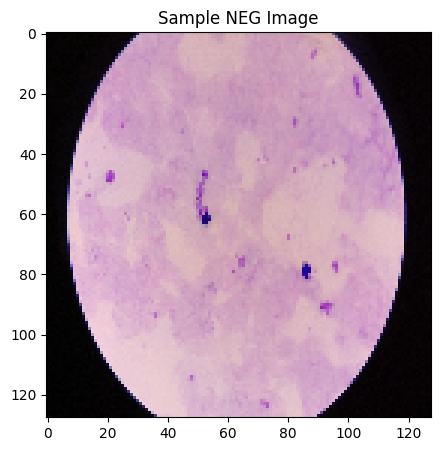

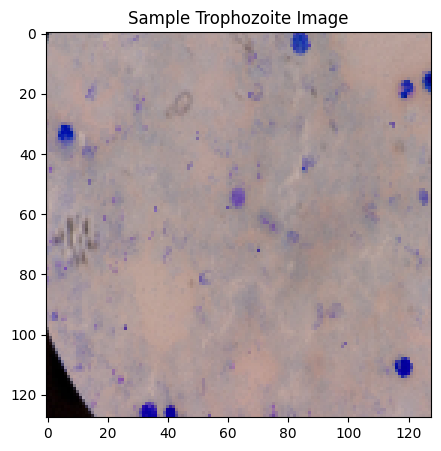

In [ ]:
# Filter rows: We filter downsampled_data to get the first NEG and WBC class image IDs.
# Get the index of the image: We match the Image_ID in downsampled_data to the index in images_array.
# Filter the rows for 'NEG' and 'WBC' classes
neg_sample_index = downsampled_data[downsampled_data['class'] == 0].index[12]
wbc_sample_index = downsampled_data[downsampled_data['class'] == 1].index[12]

# Display the first NEG image
plt.figure(figsize=(5, 5))
plt.imshow(images_array[neg_sample_index])
plt.title("Sample NEG Image")
plt.show()

# Display the first WBC image
plt.figure(figsize=(5, 5))
plt.imshow(images_array[wbc_sample_index])
plt.title("Sample Trophozoite Image")
plt.show()

# CNN


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 126, 126, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 61, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 16)                  │         100,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 196,353 (767.00 KB)

 Trainable params: 196,353 (767.00 KB)

 Non-trainable params: 0 (0.00 B)

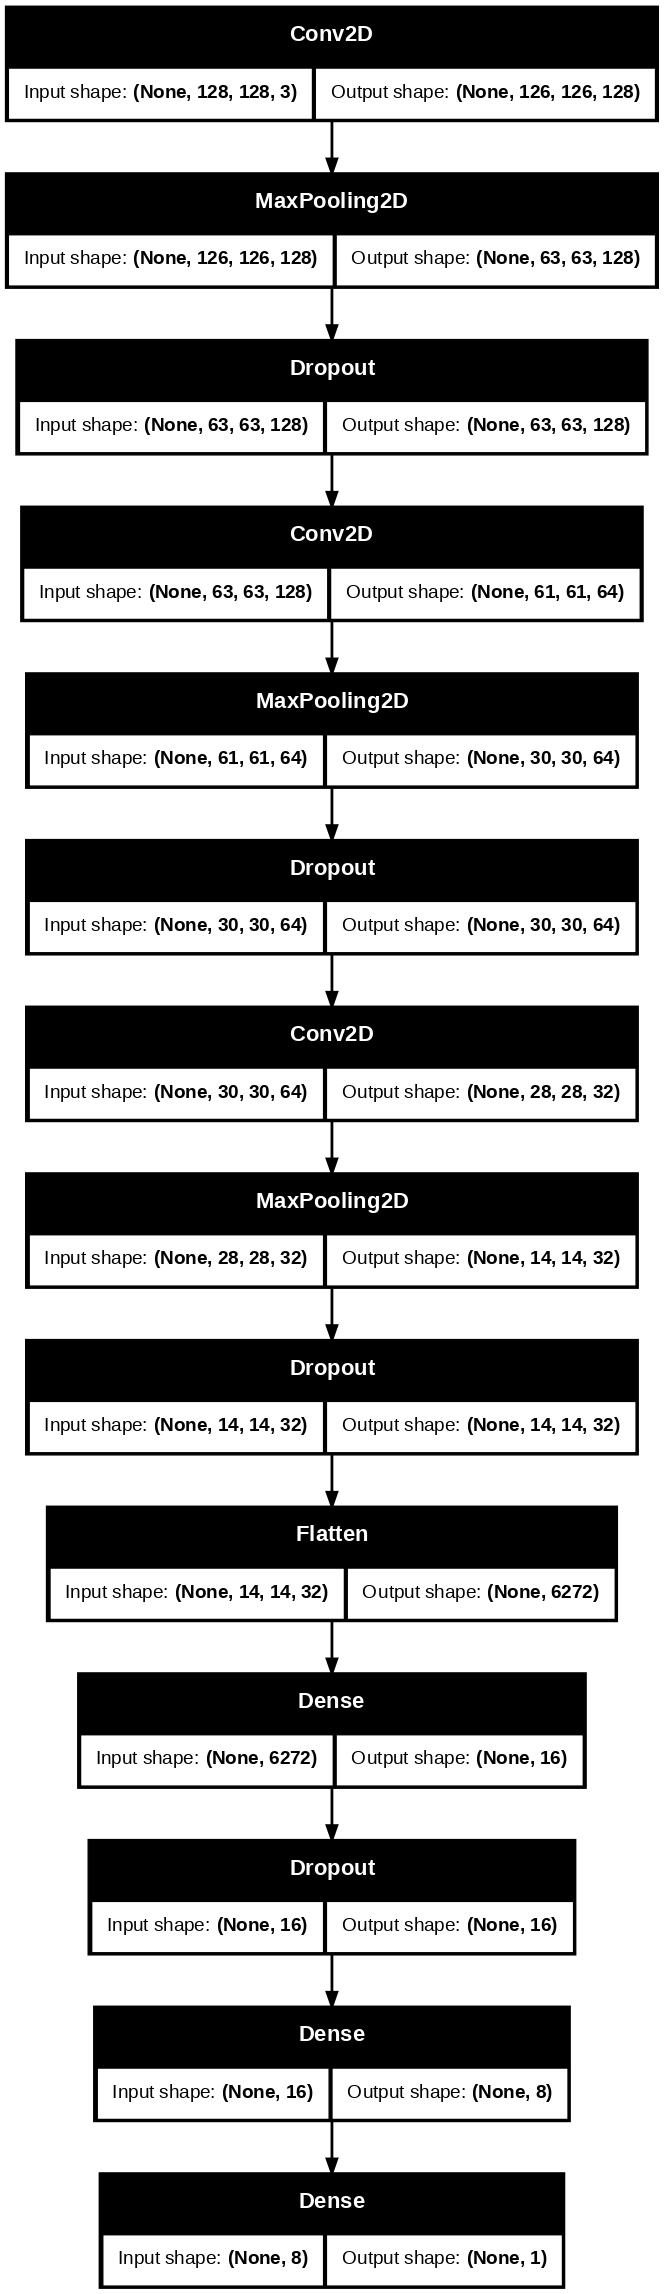

In [ ]:
# Define CNN model
cnn_model = Sequential()

# Add convolutional layers
cnn_model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)))  # Input is 128x128 image
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))  # 2nd Conv layer
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(32, (3, 3), activation='relu'))  # 3rd Conv layer
cnn_model.add(MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.5))


# Flatten feature maps for Dense layers
cnn_model.add(Flatten())

# Fully connected dense layers
cnn_model.add(Dense(16, activation='relu'))  # 1st dense layer with 128 neurons
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(8, activation='relu'))  # 2nd dense layer with 64 neurons

# Output layer
cnn_model.add(Dense(1, activation='sigmoid'))  # Output layer for multi-class classification (3 classes)

# Compiling
cnn_model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])


cnn_model.summary()
plot_model(cnn_model, show_shapes=True, dpi=100)

In [ ]:
# Training CNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
cnn_history = cnn_model.fit(
    x_train_images,  # Training image data
    y_train_Global,  # One-hot encoded labels
    validation_data=(x_test_images, y_test_Global),  # Validation data
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
)

# Make predictions
y_pred = cnn_model.predict(x_test_images)
# y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate accuracy and weighted F1 score
accuracy = accuracy_score(y_test_Global, y_pred_classes)
print(f"Best Accuracy: {accuracy}")
y_true = y_test_Global  # Ground truth labels

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5003 - loss: 0.7024 - val_accuracy: 0.5083 - val_loss: 0.6874
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5278 - loss: 0.6880 - val_accuracy: 0.5167 - val_loss: 0.6857
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5008 - loss: 0.6973 - val_accuracy: 0.6917 - val_loss: 0.6836
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5374 - loss: 0.6852 - val_accuracy: 0.9000 - val_loss: 0.6825
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5262 - loss: 0.6881 - val_accuracy: 0.9042 - val_loss: 0.6815
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5555 - loss: 0.6799 - val_accuracy: 0.7875 - val_loss: 0.6787
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5653 - loss: 0.6763 - val_accuracy: 0.7875 - val_loss: 0.6748
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5838 - loss: 0.6660 - val_accuracy: 0.9208 - v

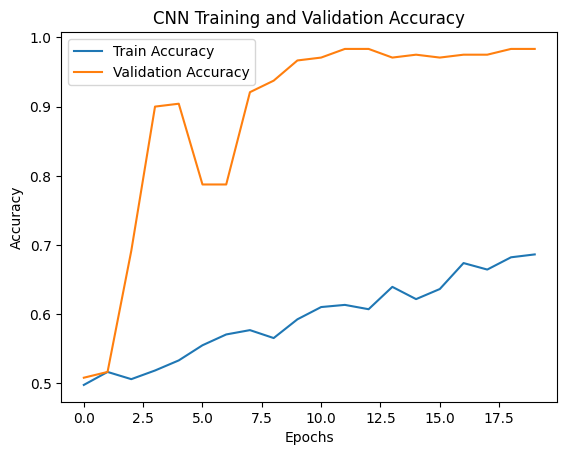

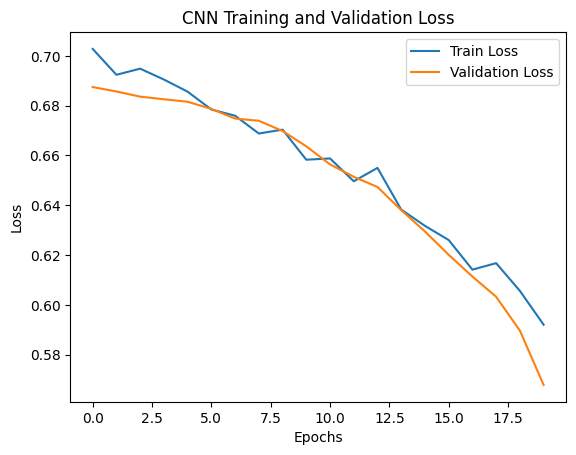

In [ ]:
# Jaskirt Kaler
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')  # CNN training accuracy
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')  # CNN validation accuracy
plt.legend()
plt.title('CNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot training and validation loss for CNN
plt.plot(cnn_history.history['loss'], label='Train Loss')  # CNN training loss
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')  # CNN validation loss
plt.legend()
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

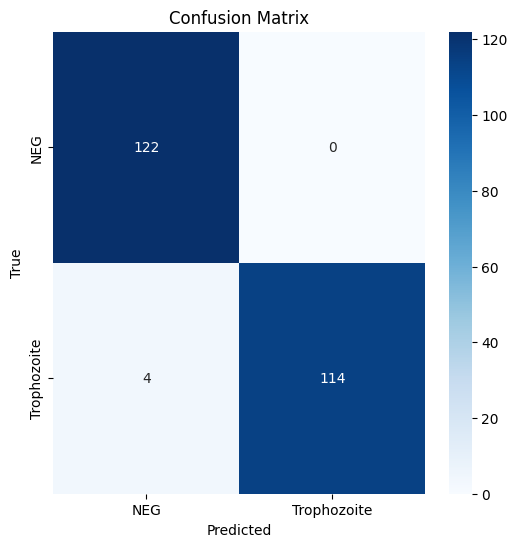

              precision    recall  f1-score   support

         NEG       0.97      1.00      0.98       122
 Trophozoite       1.00      0.97      0.98       118

    accuracy                           0.98       240
   macro avg       0.98      0.98      0.98       240
weighted avg       0.98      0.98      0.98       240



In [ ]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix with class labels
labels = ['NEG', 'Trophozoite']  # Your binary class labels
plt.figure(figsize=(6,6))  # Adjust figure size for better clarity
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))

In [ ]:
# Plot ROC curve for the model's predictions
def plot_roc_curve(pred, y_true):
    fpr, tpr, _ = roc_curve(y_true, pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


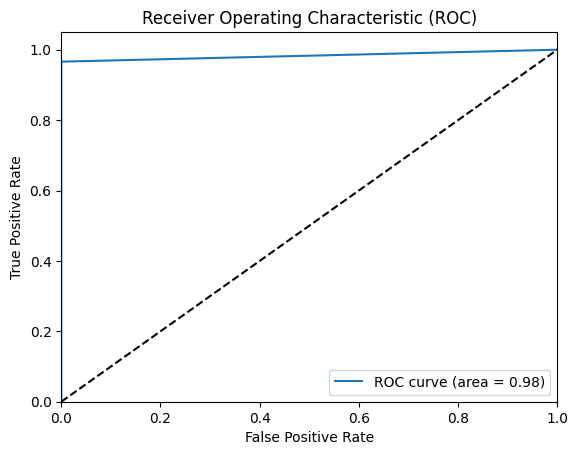

In [ ]:
# Plot the ROC curve
plot_roc_curve(y_pred_classes, y_true)